## Proyecto: ChatBot

### Participantes:

- Edwin Ramirez
- Tatiana Garcia
- Omar Alvarracin

### Contexto:

Un Chatbot por lo general usa un modelo de redes recurrentes (o sus análogos de LSTM o GRU) del tipo Seq-to-Seq para entrena un sistema automático que responda ciertas preguntas que se le hagan o sea capaz de responder e interactuar en conversaciones. En este sentido, es parecido a un modelo de traducción, con la diferencia que la salida no es el mismo texto en otro idioma, sino la respuesta natural para continuar en una conversación.

Para entrenar este modelo, es posible usar los datos de conversaciones de películas recopilada por Danescu et al. en 2011. Estos datos se conocen como “Cornell Movie – Dialogs Corpus”. Los pude encontrar en el siguiente link:
https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

La idea es entrenar un modelo de Chatbot que sea capaz sea responder e interactuar en conversaciones.

### Dataset:
(https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip)


 Librerias:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# librerias inciales
import re  # Para trabajar con expresiones regulares (búsqueda y manipulación de texto)
import pandas as pd
import numpy as np
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Model
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.callbacks import EarlyStopping
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from keras.layers import GRU

2025-05-25 18:16:15.160904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748214975.175186   47147 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748214975.179460   47147 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748214975.190961   47147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748214975.190980   47147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748214975.190982   47147 computation_placer.cc:177] computation placer alr

### Carga de datos

AL descomprimir el archivo zip, encotramos varios archivos, de acuerdo al archivo README: corresponde a un corpus que contiene una colección rica en metadatos de conversaciones ficticias extraídas de guiones de películas en bruto:

- 220,579 intercambios conversacionales entre 10,292 pares de personajes de películas
- involucra a 9,035 personajes de 617 películas
- en total 304,713 expresiones
- metadatos de películas incluidos:
	- géneros
	- año de estreno
	- calificación IMDB
	- número de votos IMDB
	- calificación IMDB
- metadatos de personajes incluidos:
	- género (para 3,774 personajes)
	- posición en los créditos de la película (para 3,321 personajes)


En cuanto a los archivos que hacen parte del corpus encotramos:
- movie_titles_metadata.txt
- movie_characters_metadata.txt
- movie_lines.txt
- movie_conversations.txt
- raw_script_urls.txt

Para el contexto del proyecto y luego de revisar los archivos manualmente, se determino que los archivos a usar son (movie_lines.txt y movie_conversations.txt) por que son los que contiene los dialogos de cada pelicula y tiene el contesto de pregunta respuestas en algunos casos; lo cual puede ser util para la generacion de la herramienta.

 Carga de datos:

Cargamos el archivo movie_lines.txt

In [3]:
lineas = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [4]:
lineas[:10]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.",
 'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow',
 "L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.",
 'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No',
 'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?']

In [5]:
#tamaño de la lista
len(lineas)

304714

Cargamos el archivo movie_conversations.txt

In [6]:
conver_lineas = open('cornell movie-dialogs corpus/movie_conversations.txt',encoding='utf-8', errors='ignore').read().split('\n')

In [7]:
conver_lineas[:10]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']"]

In [8]:
#tamaño de conver_lineas
print("Número de líneas en movie_conversations.txt:", len(conver_lineas))

Número de líneas en movie_conversations.txt: 83098


Podemos ver que existe una relacion entre los archivos, En el archivo de conversacion indica con un codigo cada linea y las agrupa para identificar una conversacion.

Deacuerdo al archivo README, indica que el separador usado entre valores es '+++$+++'.

In [9]:
# Crea una lista de todos los ids de líneas de conversaciones.

conversaciones = [ ]
for k in conver_lineas:
    conversaciones.append(k.split(' +++$+++ ')[-1][1:-1].replace("'"," ").replace(",","").split())

# Imprime los primeros 10 elementeos
conversaciones[:10]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]

In [10]:
# Genramos un diccionario para relacionar el id de la linea con el texto
dialogos = {}
for linea in lineas:
    dialogos[linea.split(' +++$+++ ')[0]] = linea.split(' +++$+++ ')[-1]

# Imprime los primeros 20 elementos
count = 0
for key, value in dialogos.items():
    print(f"'{key}': '{value}'")
    count += 1
    if count == 20:
        break

'L1045': 'They do not!'
'L1044': 'They do to!'
'L985': 'I hope so.'
'L984': 'She okay?'
'L925': 'Let's go.'
'L924': 'Wow'
'L872': 'Okay -- you're gonna need to learn how to lie.'
'L871': 'No'
'L870': 'I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?'
'L869': 'Like my fear of wearing pastels?'
'L868': 'The "real you".'
'L867': 'What good stuff?'
'L866': 'I figured you'd get to the good stuff eventually.'
'L865': 'Thank God!  If I had to hear one more story about your coiffure...'
'L864': 'Me.  This endless ...blonde babble. I'm like, boring myself.'
'L863': 'What crap?'
'L862': 'do you listen to this crap?'
'L861': 'No...'
'L860': 'Then Guillermo says, "If you go any lighter, you're gonna look like an extra on 90210."'
'L699': 'You always been this selfish?'


In [11]:
del(lineas, conver_lineas, k, linea)

Se debe clasificar los dialogos en preguntas que seria las entradas y respuesta que serian las salidas o respuestas deseadas.

In [12]:
# Se clasifican los dialogos:
preguntas = []
respuestas = []

for conv in conversaciones:
    for i in range(len(conv)-1):
        preguntas.append(dialogos[conv[i]])
        respuestas.append(dialogos[conv[i+1]])

In [13]:
respuestas[10]

"Right.  See?  You're ready for the quiz."

- Borramos las varaibles que ya no vamos a usar.

In [14]:
del (dialogos, conversaciones, conv, i)

- Filtramos las preguntas y respuestas para que no tengan mas de 13 caracteres.


In [15]:
orden_preguntas = []
orden_respuestas = []

for i in range(len(preguntas)):
    if len(preguntas[i]) < 13:
        orden_preguntas.append(preguntas[i])
        orden_respuestas.append(respuestas[i])

- Funsion para limpiarel texto eliminando caracteres innecesarios y modificando el formato de las palabras.

In [16]:
def limpia_texto(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"it's", "it is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"how's", "how is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "cannot", txt)
    txt = re.sub(r"n't", " not", txt)
    txt = re.sub(r"n'", "ng", txt)
    txt = re.sub(r"'bout", "about", txt)
    txt = re.sub(r"'til", "until", txt)
    txt = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", txt)
    return txt

- Limpanos las preguntas y las respuestas

In [17]:
preguntas_limpias = []
for linea_pregunta in orden_preguntas:
    preguntas_limpias.append(limpia_texto(linea_pregunta))

respuestas_limpias = []
for linea_respuesta in orden_respuestas:
    respuestas_limpias.append(limpia_texto(linea_respuesta))

In [18]:
preguntas_limpias[:5]

['cameron', 'why', 'there', 'sure have', 'hi']

In [19]:
respuestas_limpias[:5]

['the thing is cameron  i am at the mercy of a particularly hideous breed of loser  my sister  i cannot date until she does',
 'unsolved mystery  she used to be really popular when she started high school then it was just like she got sick of it or something',
 'where',
 'i really really really wanna go but i cannot  not unless my sister goes',
 'looks like things worked out tonight huh']

- Limitamos las respuestas a 15 palabras para mantener consistencia en el tamaño de las secuencias

In [20]:
for i in range(len(respuestas_limpias)):
    respuestas_limpias[i] = ' '.join(respuestas_limpias[i].split()[:15])

- Borramos las varaibles que ya no vamos a usar.

In [21]:
del(respuestas, preguntas, linea_respuesta, linea_pregunta,orden_respuestas, orden_preguntas)

- Limitamos el tamaño del dataset a 15000 preguntas y respuestas para reducir el tiempo de entrenamiento

In [22]:
# trimming
#respuestas_limpias=respuestas_limpias[:30000]
#preguntas_limpias=preguntas_limpias[:30000]

- Crear un diccionario para la frecuencia del vocabulario.

In [23]:
palabra_cont = {}
for linea in preguntas_limpias:
    for palabra in linea.split():
        if palabra not in palabra_cont:
            palabra_cont[palabra] = 1
        else:
            palabra_cont[palabra] += 1

for linea in respuestas_limpias:
    for palabra in linea.split():
        if palabra not in palabra_cont:
            palabra_cont[palabra] = 1
        else:
            palabra_cont[palabra] += 1

del(linea, palabra)

In [24]:
palabra_cont

{'cameron': 12,
 'why': 1611,
 'there': 898,
 'sure': 591,
 'have': 2649,
 'hi': 569,
 'i': 12861,
 'was': 1698,
 'well': 1180,
 'no': 3384,
 'but': 1247,
 'what': 6290,
 'crap': 16,
 'wow': 58,
 'she': 1130,
 'okay': 818,
 'they': 1163,
 'do': 4034,
 'to': 5805,
 'who': 1182,
 'great': 237,
 'it': 6409,
 'is': 7550,
 'more': 291,
 'queen': 12,
 'harry': 63,
 'neat': 8,
 'joey': 22,
 'that': 3634,
 'not': 5653,
 'let': 286,
 'go': 1087,
 'daddy': 68,
 'never': 438,
 'thirtytwo': 2,
 'get': 1096,
 'out': 1010,
 'he': 2464,
 'pretty': 132,
 'away': 195,
 'yeah': 2094,
 'am': 2572,
 'on': 1550,
 'forget': 108,
 'hey': 451,
 "who's": 189,
 'this': 1918,
 'you': 13661,
 'did': 1386,
 'excuse': 149,
 'me': 3126,
 'told': 265,
 'dorsey': 2,
 'hate': 78,
 'him': 937,
 'busy': 29,
 'maybe': 332,
 'bianca': 5,
 'wholesome': 1,
 'unwelcome': 3,
 'good': 838,
 'call': 288,
 'yes': 2793,
 'how': 1325,
 'fallacy': 1,
 'the': 7349,
 'duck': 7,
 'hearsay': 2,
 'peas': 2,
 'tell': 627,
 'oh': 1401,
 'h

- Eliminamos palabras raras del vocabulario.
- Su objetivo es reemplazar menos del 10% de las palabras con `<UNK>`

In [25]:
umbral = 10
vocabulario = {}
palabra_num = 0
for palabra, cont in palabra_cont.items():
    if cont >= umbral:
        vocabulario[palabra] = palabra_num
        palabra_num += 1

print("Tamaño del vocavulario total:", len(vocabulario))
print("Tamaño del vocabulario que usaremos:", palabra_num)

Tamaño del vocavulario total: 1840
Tamaño del vocabulario que usaremos: 1840


In [26]:
vocabulario

{'cameron': 0,
 'why': 1,
 'there': 2,
 'sure': 3,
 'have': 4,
 'hi': 5,
 'i': 6,
 'was': 7,
 'well': 8,
 'no': 9,
 'but': 10,
 'what': 11,
 'crap': 12,
 'wow': 13,
 'she': 14,
 'okay': 15,
 'they': 16,
 'do': 17,
 'to': 18,
 'who': 19,
 'great': 20,
 'it': 21,
 'is': 22,
 'more': 23,
 'queen': 24,
 'harry': 25,
 'joey': 26,
 'that': 27,
 'not': 28,
 'let': 29,
 'go': 30,
 'daddy': 31,
 'never': 32,
 'get': 33,
 'out': 34,
 'he': 35,
 'pretty': 36,
 'away': 37,
 'yeah': 38,
 'am': 39,
 'on': 40,
 'forget': 41,
 'hey': 42,
 "who's": 43,
 'this': 44,
 'you': 45,
 'did': 46,
 'excuse': 47,
 'me': 48,
 'told': 49,
 'hate': 50,
 'him': 51,
 'busy': 52,
 'maybe': 53,
 'good': 54,
 'call': 55,
 'yes': 56,
 'how': 57,
 'the': 58,
 'tell': 59,
 'oh': 60,
 'huh': 61,
 'wait': 62,
 'know': 63,
 'parts': 64,
 'of': 65,
 'which': 66,
 'when': 67,
 'think': 68,
 'right': 69,
 'say': 70,
 'plan': 71,
 'father': 72,
 'chief': 73,
 'knows': 74,
 'long': 75,
 'thank': 76,
 'we': 77,
 'are': 78,
 'lost':

- Borramos las varaibles que ya no vamos a usar.

In [27]:
del(palabra_cont,palabra,cont,umbral,palabra_num)

- Agregamos tokens especiales al vocabulario (`<PAD>`, `<EOS>`, `<OUT>`, `<SOS>`)
- Asignamos valores numéricos a los tokens
- Creamos un diccionario inverso para mapear números a palabras
- Hacemos un caso especial para 'cameron' asignándole el mismo valor que `<PAD>`

Los tokens especiales son:
- `<PAD>`: Se usa para rellenar secuencias y hacer que todas tengan la misma longitud
- `<EOS>`: End of Sequence - Marca el final de una secuencia
- `<OUT>`: Out of Vocabulary - Para palabras que no están en el vocabulario
- `<SOS>`: Start of Sequence - Marca el inicio de una secuencia



In [28]:
for i in range(len(respuestas_limpias)):
    respuestas_limpias[i] = '<SOS> ' + respuestas_limpias[i] + ' <EOS>'

tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocabulario)

for token in tokens:
    vocabulario[token] = x
    x += 1

vocabulario['cameron'] = vocabulario['<PAD>']
vocabulario['<PAD>'] = 0

del(x,token, tokens)

# Inverse Answers Dictionary
inv_vocab = {w:v for v, w in vocabulario.items()}
del(i)

Codificación de las preguntas y respuestas:
- Convertimos cada palabra de las preguntas o respuestas a su valor numérico correspondiente del vocabulario
- Si una palabra no está en el vocabulario, se reemplaza con el token `<OUT>`
- El resultado es una lista de listas donde cada sublista contiene los valores numéricos de las palabras

In [29]:
entrada_codificador = []
for linea in preguntas_limpias:
    lista = []
    for palabra in linea.split():
        if palabra not in vocabulario:
            lista.append(vocabulario['<OUT>'])
        else:
            lista.append(vocabulario[palabra])

    entrada_codificador.append(lista)

In [30]:
entrada_codificador[:2]

[[1840], [1]]

In [31]:
entrada_decodificador = []
for linea in respuestas_limpias:
    lista = []
    for palabra in linea.split():
        if palabra not in vocabulario:
            lista.append(vocabulario['<OUT>'])
        else:
            lista.append(vocabulario[palabra])
    entrada_decodificador.append(lista)

In [32]:
entrada_decodificador[:2]

[[1843,
  58,
  469,
  22,
  1840,
  6,
  39,
  258,
  58,
  1842,
  65,
  82,
  1842,
  1842,
  1842,
  65,
  1841],
 [1843,
  1842,
  793,
  14,
  862,
  18,
  209,
  115,
  1842,
  67,
  14,
  1528,
  556,
  901,
  80,
  21,
  1841]]

- Borramos las varaibles que ya no vamos a usar.

In [33]:
del(respuestas_limpias, preguntas_limpias, linea, lista, palabra)

- Padding de las entradas para el modelo LSTM

In [34]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

from keras.preprocessing.sequence import pad_sequences

- Ajuste de las secuencias de entrada y salida para el modelo LSTM

In [35]:
# Padding de las preguntas  (entrada del codificador)
entrada_codificador = pad_sequences(entrada_codificador, 13, padding='post', truncating='post')

# Padding de las respuestas (entrada del decodificador)
entrada_decodificador = pad_sequences(entrada_decodificador, 13, padding='post', truncating='post')

- Generar la salida final del decodificador (shift a la izquierda)

In [36]:
salida_final_decodificador = []
for seq in entrada_decodificador:
    salida_final_decodificador.append(seq[1:])
salida_final_decodificador = pad_sequences(salida_final_decodificador, 13, padding='post', truncating='post')
del(seq)

- Codificación one-hot de la salida final del decodificador

In [37]:
salida_final_decodificador = to_categorical(salida_final_decodificador, len(vocabulario))
print(salida_final_decodificador.shape)

(31416, 13, 1844)


### Creación de un modelo de codificación mediante LSTM

#### Calibración hiper parámetros LSMT

In [38]:
#pip install keras-tuner

In [39]:
TAM_VOCAB = len(vocabulario)
class ChatbotHyperModel(HyperModel):
    def __init__(self, vocab_size, input_length):
        self.vocab_size = vocab_size
        self.input_length = input_length

    def build(self, hp):
        # Inputs
        entrada_cod = Input(shape=(self.input_length,))
        entrada_dec = Input(shape=(self.input_length,))

        # Hiperparámetros
        embed_dim = hp.Choice('embedding_dim', [128])
        #embed_dim = hp.Choice('embedding_dim', [32, 50, 64, 128])
        lstm_units = hp.Choice('lstm_units', [200])
        #lstm_units = hp.Choice('lstm_units', [64, 128, 200, 500])
        learning_rate = hp.Choice('learning_rate', [1e-3,])
        #learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

        # Embedding
        embedding_cod = Embedding(input_dim=self.vocab_size+1,
                              output_dim=embed_dim,
                              input_length=self.input_length,
                              trainable=True)
        
        embedding_dec = Embedding(input_dim=self.vocab_size+1,  
                                output_dim=embed_dim,
                                input_length=self.input_length,
                                trainable=True)

        cod_embed = embedding_cod(entrada_cod)
        cod_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        cod_salida, h, c = cod_lstm(cod_embed)
        estados_cod = [h, c]

        dec_embed = embedding_dec(entrada_dec)
        dec_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        dec_salida, _, _ = dec_lstm(dec_embed, initial_state=estados_cod)

        densa = Dense(self.vocab_size, activation='softmax')
        salida_densa = densa(dec_salida)

        modelo = Model([entrada_cod, entrada_dec], salida_densa)

        modelo.compile(
            loss='categorical_crossentropy',
            optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['acc']
        )

        return modelo


# Define el modelo hypermodel
hypermodel = ChatbotHyperModel(vocab_size=TAM_VOCAB, input_length=13)

# Inicializa el tuner
import shutil

# Borra el directorio del tuner si existe para evitar conflictos de tamaño de vocabulario
tuner_dir = r'C:/Users/Usuario/Desktop/keras_tuner_dir/chatbot1_seq2seq'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    max_trials=10,  # número de combinaciones a probar
    executions_per_trial=1,
    directory=r'C:/Users/Usuario/Desktop/keras_tuner_dir', # Cambia esto a tu directorio
    project_name='chatbot1_seq2seq'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5,       # N° de épocas sin mejora antes de detener
    restore_best_weights=True
)
# Inicia la búsqueda
tuner.search(
    [entrada_codificador, entrada_decodificador],
    salida_final_decodificador,
    epochs=60,
    #batch_size=64,
    #validation_split=0.2,
    callbacks=[early_stop],
    #verbose=1
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros encontrados:")
print(f"Embedding dim: {best_hps.get('embedding_dim')}")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


Trial 1 Complete [00h 18m 35s]

Best val_acc So Far: None
Total elapsed time: 00h 18m 35s
Mejores hiperparámetros encontrados:
Embedding dim: 128
LSTM units: 200
Learning rate: 0.001


In [40]:
tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Reconstruir el modelo manualmente:
modelLMS = hypermodel.build(best_hps)



Results summary
Results in C:/Users/Usuario/Desktop/keras_tuner_dir/chatbot1_seq2seq
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 00 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 200
learning_rate: 0.001
Traceback (most recent call last):
  File "/home/rezed/deepl/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/rezed/deepl/lib/python3.12/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/home/rezed/deepl/lib/python3.12/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rezed/deepl/lib/python3.12/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in conv

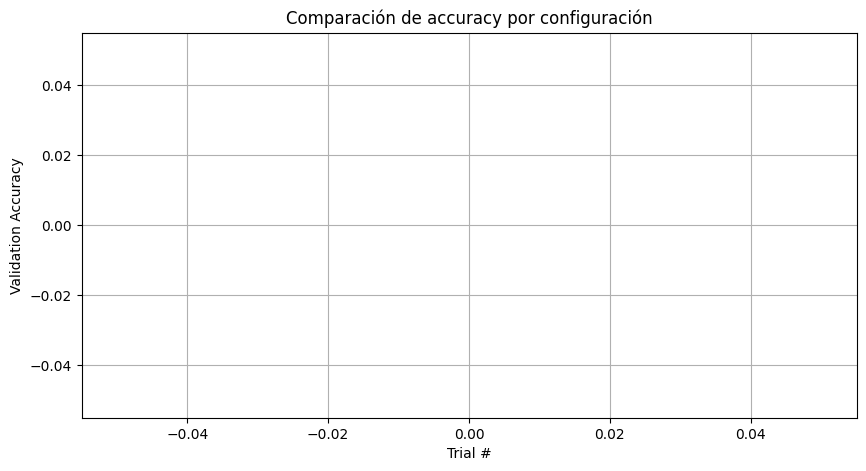

In [41]:
# Obtener los trials correctamente desde el oracle
trials = list(tuner.oracle.trials.values())

# Extraer datos
val_accs = [trial.score for trial in trials]
embedding_dims = [trial.hyperparameters.get('embedding_dim') for trial in trials]
lstm_units = [trial.hyperparameters.get('lstm_units') for trial in trials]

# Crear gráfico
plt.figure(figsize=(10, 5))
plt.plot(val_accs, marker='o')
plt.title('Comparación de accuracy por configuración')
plt.xlabel('Trial #')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

  trial_id val_acc  embedding_dim  lstm_units  learning_rate
0       00    None            128         200          0.001


Text(0.5, 0, 'Embedding Dimension')

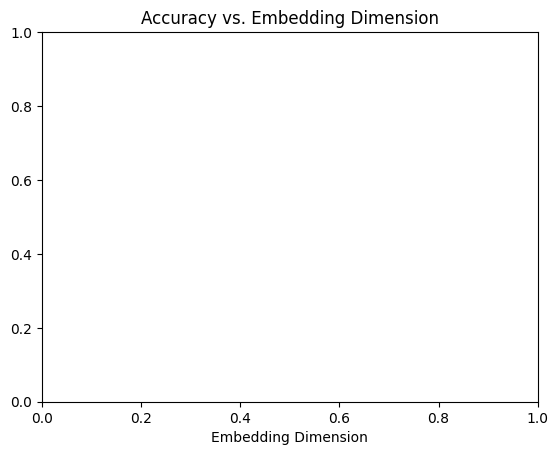

In [42]:

df = pd.DataFrame([
    {
        'trial_id': trial.trial_id,
        'val_acc': trial.score,
        'embedding_dim': trial.hyperparameters.get('embedding_dim'),
        'lstm_units': trial.hyperparameters.get('lstm_units'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
    }
    for trial in trials
])

print(df.sort_values(by='val_acc', ascending=False))

# También puedes hacer gráficos de dispersión

sns.scatterplot(data=df, x='embedding_dim', y='val_acc', hue='lstm_units')
plt.title('Accuracy vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')

#### Correr modelo con parámetros calibrados-- Cambiarlos de ser necesario

In [43]:
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Input

In [44]:
# Definición de las capas de entrada
entrada_cod = Input(shape=(13, ))
entrada_dec = Input(shape=(13, ))

In [45]:
# Tamaño del vocabulario y capa de embedding
TAM_VOCAB = len(vocabulario)
embedding = Embedding(TAM_VOCAB+1, output_dim=128,
                     input_length=13,
                     trainable=True
                    )

In [46]:
# Codificador
cod_embed = embedding(entrada_cod)
cod_lstm = LSTM(200, return_sequences=True, return_state=True)
cod_salida, h, c = cod_lstm(cod_embed)
estados_cod = [h, c]

In [47]:
# Decodificador
dec_embed = embedding(entrada_dec)
dec_lstm = LSTM(200, return_sequences=True, return_state=True)
dec_salida, _, _ = dec_lstm(dec_embed, initial_state=estados_cod)

In [48]:
# Capa densa de salida
densa = Dense(TAM_VOCAB, activation='softmax')
salida_densa = densa(dec_salida)

In [49]:
# Definición del modelo
modelo = Model([entrada_cod, entrada_dec], salida_densa)

# Compilación
modelo.compile(loss='categorical_crossentropy',
              metrics=['acc'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [50]:
# Entrenamiento
early_stop = EarlyStopping(monitor='loss', patience=5,       # N° de épocas sin mejora antes de detener
    restore_best_weights=True)
modelo.fit([entrada_codificador, entrada_decodificador],
          salida_final_decodificador,
          epochs=500,
          #batch_size=64,
          callbacks=[early_stop])

2025-05-25 18:34:58.194689: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3012417408 exceeds 10% of free system memory.
2025-05-25 18:34:59.859866: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3012417408 exceeds 10% of free system memory.


Epoch 1/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - acc: 0.4567 - loss: 3.3815
Epoch 2/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - acc: 0.5209 - loss: 2.6668
Epoch 3/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - acc: 0.5300 - loss: 2.5503
Epoch 4/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - acc: 0.5356 - loss: 2.4736
Epoch 5/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - acc: 0.5390 - loss: 2.4277
Epoch 6/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - acc: 0.5416 - loss: 2.3855
Epoch 7/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - acc: 0.5416 - loss: 2.3637
Epoch 8/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - acc: 0.5464 - loss: 2.3229
Epoch 9/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - acc: 0.5488 - loss: 2.2916
Epoch 10/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - acc: 0.5495 - loss: 2.2743
Epoch 11/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - acc: 0.5493 - loss: 2.2567
Epoch 12/60
982/982 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - acc: 0.5529 - loss: 2.2204
E

### Creación de un modelo de decodificación mediante LSTM

In [51]:
from keras.models import Model
from keras.layers import Input

In [52]:
# Modelo codificador
modelo_cod = Model([entrada_cod], estados_cod)

# Modelo decodificador
estado_entrada_h = Input(shape=(200,))
estado_entrada_c = Input(shape=(200,))

estados_entrada_dec = [estado_entrada_h, estado_entrada_c]

salidas_dec, estado_h, estado_c = dec_lstm(dec_embed,
                                         initial_state=estados_entrada_dec)

estados_dec = [estado_h, estado_c]

modelo_dec = Model([entrada_dec] + estados_entrada_dec,
                  [salidas_dec] + estados_dec)

modelo_dec.compile(loss='categorical_crossentropy',
                  metrics=['acc'],
                  optimizer='adam')


In [55]:
print("Inicio de ChatBot")
print("-"*45)
prepro1 = ""
while prepro1 != 'q':
    prepro1 = input("Tu pregunta: ")
    
    prepro1 = limpia_texto(prepro1)
    prepro = [prepro1]

    txt = []
    for x in prepro:
        lst = []
        for y in x.split():
            try:
                lst.append(vocabulario[y])
            except:
                lst.append(vocabulario['<OUT>'])
        txt.append(lst)
    txt = pad_sequences(txt, 13, padding='post')
    stat = modelo_cod.predict(txt, verbose=0)
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = vocabulario['<SOS>']
    stop_condition = False
    decoded_translation = ""

    while not stop_condition:
        dec_outputs, h, c = modelo_dec.predict([empty_target_seq] + stat, verbose=0)
        decoder_concat_input = densa(dec_outputs)
        sampled_word_index = np.argmax(decoder_concat_input[0, -1, :])
        sampled_word = inv_vocab.get(sampled_word_index, '<OUT>') + ' '
        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word
        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
            stop_condition = True
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        stat = [h, c]
    print("Respuesta BOT: ", decoded_translation.strip())


Inicio de ChatBot
---------------------------------------------


Tu pregunta:  hi


Respuesta BOT:  hi


Tu pregunta:  how are you


Respuesta BOT:  fine


Tu pregunta:  what is your name


Respuesta BOT:  <OUT>


Tu pregunta:  how old are you ?


Respuesta BOT:  i am fine


Tu pregunta:  How is the weather ?


Respuesta BOT:  you know what i am talking about


Tu pregunta:  what is the time right now ?


Respuesta BOT:  i will be there


Tu pregunta:  really


Respuesta BOT:  yeah


Tu pregunta:  q


Respuesta BOT:  <OUT>
